# Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/chibaryowei/anaconda3/lib/pytho

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [0.2,0.5,0.8]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=5, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0722 22:07:40.727370 4672189888 deprecation_wrapper.py:119] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 22:07:40.728567 4672189888 deprecation_wrapper.py:119] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 22:07:40.733997 4672189888 deprecation_wrapper.py:119] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 22:07:40.826408 4672189888 deprecation_wrapper.py:119] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.place

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 0


W0722 22:07:40.980076 4672189888 deprecation_wrapper.py:119] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0722 22:07:40.997785 4672189888 deprecation_wrapper.py:119] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,642,890
Trainable params: 1,641,610
Non-trainable params: 1,280
______________________________________________________________

W0722 22:07:41.365843 4672189888 deprecation.py:323] From /Users/chibaryowei/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 172us/step - loss: 2.1355 - acc: 0.2800 - val_loss: 1.9944 - val_acc: 0.3242
Epoch 2/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.7274 - acc: 0.3952 - val_loss: 1.7753 - val_acc: 0.3771
Epoch 3/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.6279 - acc: 0.4314 - val_loss: 1.6708 - val_acc: 0.4119
Epoch 4/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.5676 - acc: 0.4532 - val_loss: 1.6246 - val_acc: 0.4249
Epoch 5/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.5230 - acc: 0.4689 - val_loss: 1.5808 - val_acc: 0.4427
Epoch 6/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4864 - acc: 0.4810 - val_loss: 1.5572 - val_acc: 0.4508
Epoch 7/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.4520 - acc: 0.4947 - val_loss: 1.5337 - 

Numbers of exp: 2, reduce_factor: 0.20, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,642,890
Trainable params: 1,641,610
Non-trainable params: 1,280
____

50000/50000 [==============================] - 7s 132us/step - loss: 1.2162 - acc: 0.5768 - val_loss: 1.4473 - val_acc: 0.4900
Epoch 18/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.1990 - acc: 0.5846 - val_loss: 1.4368 - val_acc: 0.4927
Epoch 19/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.1797 - acc: 0.5924 - val_loss: 1.4254 - val_acc: 0.5030
Epoch 20/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.1619 - acc: 0.5981 - val_loss: 1.4272 - val_acc: 0.4995
Epoch 21/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.1438 - acc: 0.6049 - val_loss: 1.4283 - val_acc: 0.5007
Epoch 22/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.1283 - acc: 0.6099 - val_loss: 1.4231 - val_acc: 0.5011
Epoch 23/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.1110 - acc: 0.6178 - val_loss: 1.4237 - val_acc: 0.5058
Epoch 24/25
50000/50000 [==============

50000/50000 [==============================] - 8s 161us/step - loss: 1.4125 - acc: 0.5111 - val_loss: 1.5212 - val_acc: 0.4647
Epoch 9/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.3847 - acc: 0.5206 - val_loss: 1.5101 - val_acc: 0.4652
Epoch 10/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.3596 - acc: 0.5294 - val_loss: 1.4922 - val_acc: 0.4694
Epoch 11/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.3356 - acc: 0.5354 - val_loss: 1.4839 - val_acc: 0.4728
Epoch 12/25
50000/50000 [==============================] - 11s 219us/step - loss: 1.3157 - acc: 0.5440 - val_loss: 1.4758 - val_acc: 0.4758
Epoch 13/25
50000/50000 [==============================] - 10s 202us/step - loss: 1.2939 - acc: 0.5523 - val_loss: 1.4743 - val_acc: 0.4741
Epoch 14/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.2729 - acc: 0.5605 - val_loss: 1.4747 - val_acc: 0.4759
Epoch 15/25
50000/50000 [=============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 200us/step - loss: 2.3368 - acc: 0.2334 - val_loss: 2.1416 - val_acc: 0.2911
Epoch 2/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.8493 - acc: 0.3608 - val_loss: 1.8754 - val_acc: 0.3609
Epoch 3/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.7231 - acc: 0.3979 - val_loss: 1.7952 - val_acc: 0.3804
Epoch 4/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.6570 - acc: 0.4185 - val_loss: 1.7145 - val_acc: 0.4056
Epoch 5/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.6107 - acc: 0.4363 - val_loss: 1.6826 - val_acc: 0.4085
Epoch 6/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.5755 - acc: 0.4510 - val_loss: 1.6497 - val_acc: 0.4189
Epoch 7/25
50000/50000 [==============================] - 12s 240us/step - loss: 1.5445 - acc: 0.4625 - val_loss: 1.6199 

50000/50000 [==============================] - 10s 205us/step - loss: 1.2523 - acc: 0.5683 - val_loss: 1.4689 - val_acc: 0.4800
Numbers of exp: 9, reduce_factor: 0.20, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)        

50000/50000 [==============================] - 11s 223us/step - loss: 1.0628 - acc: 0.6387 - val_loss: 1.4598 - val_acc: 0.4824
Epoch 15/25
50000/50000 [==============================] - 16s 315us/step - loss: 1.0396 - acc: 0.6459 - val_loss: 1.4012 - val_acc: 0.5077
Epoch 16/25
50000/50000 [==============================] - 18s 360us/step - loss: 1.0162 - acc: 0.6545 - val_loss: 1.4066 - val_acc: 0.5079
Epoch 17/25
50000/50000 [==============================] - 19s 371us/step - loss: 0.9994 - acc: 0.6610 - val_loss: 1.4970 - val_acc: 0.4850
Epoch 18/25
50000/50000 [==============================] - 15s 306us/step - loss: 0.9795 - acc: 0.6708 - val_loss: 1.4853 - val_acc: 0.4931
Epoch 19/25
50000/50000 [==============================] - 14s 271us/step - loss: 0.9547 - acc: 0.6809 - val_loss: 1.4819 - val_acc: 0.4789
Epoch 20/25
50000/50000 [==============================] - 13s 252us/step - loss: 0.9309 - acc: 0.6892 - val_loss: 1.4415 - val_acc: 0.5000

Epoch 00020: ReduceLROnPlateau 

50000/50000 [==============================] - 11s 226us/step - loss: 1.4016 - acc: 0.5122 - val_loss: 1.6116 - val_acc: 0.4309
Epoch 5/25
50000/50000 [==============================] - 11s 215us/step - loss: 1.3563 - acc: 0.5292 - val_loss: 1.5274 - val_acc: 0.4631
Epoch 6/25
50000/50000 [==============================] - 11s 213us/step - loss: 1.3182 - acc: 0.5434 - val_loss: 1.5505 - val_acc: 0.4614
Epoch 7/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.2886 - acc: 0.5542 - val_loss: 1.4760 - val_acc: 0.4807
Epoch 8/25
50000/50000 [==============================] - 12s 235us/step - loss: 1.2548 - acc: 0.5678 - val_loss: 1.4634 - val_acc: 0.4916
Epoch 9/25
50000/50000 [==============================] - 12s 240us/step - loss: 1.2258 - acc: 0.5788 - val_loss: 1.4374 - val_acc: 0.4967
Epoch 10/25
50000/50000 [==============================] - 12s 237us/step - loss: 1.1991 - acc: 0.5890 - val_loss: 1.4642 - val_acc: 0.4869
Epoch 11/25
50000/50000 [============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 311us/step - loss: 1.9149 - acc: 0.3483 - val_loss: 1.9180 - val_acc: 0.3786
Epoch 2/25
50000/50000 [==============================] - 11s 225us/step - loss: 1.5979 - acc: 0.4427 - val_loss: 1.6766 - val_acc: 0.4188
Epoch 3/25
50000/50000 [==============================] - 12s 248us/step - loss: 1.5210 - acc: 0.4724 - val_loss: 1.6064 - val_acc: 0.4356
Epoch 4/25
50000/50000 [==============================] - 12s 237us/step - loss: 1.4710 - acc: 0.4905 - val_loss: 1.5810 - val_acc: 0.4385
Epoch 5/25
50000/50000 [==============================] - 12s 232us/step - loss: 1.4298 - acc: 0.5051 - val_loss: 1.5346 - val_acc: 0.4597
Epoch 6/25
50000/50000 [==============================] - 12s 240us/step - loss: 1.3954 - acc: 0.5176 - val_loss: 1.5516 - val_acc: 0.4526
Epoch 7/25
50000/50000 [==============================] - 15s 297us/step - loss: 1.3666 - acc: 0.5286 - val_loss: 1.

Epoch 25/25
50000/50000 [==============================] - 12s 235us/step - loss: 1.2026 - acc: 0.5907 - val_loss: 1.4481 - val_acc: 0.4947
Numbers of exp: 16, reduce_factor: 0.80, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_33 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
batch_normalization_34 (Batc (None, 128)               512       
_________________________________________________________________
output (D

Epoch 16/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.2956 - acc: 0.5563 - val_loss: 1.4839 - val_acc: 0.4785
Epoch 17/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.2833 - acc: 0.5613 - val_loss: 1.4742 - val_acc: 0.4820
Epoch 18/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.2739 - acc: 0.5643 - val_loss: 1.4891 - val_acc: 0.4778
Epoch 19/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.2628 - acc: 0.5693 - val_loss: 1.4696 - val_acc: 0.4838
Epoch 20/25
50000/50000 [==============================] - 14s 275us/step - loss: 1.2525 - acc: 0.5735 - val_loss: 1.4661 - val_acc: 0.4839
Epoch 21/25
50000/50000 [==============================] - 12s 241us/step - loss: 1.2430 - acc: 0.5758 - val_loss: 1.4757 - val_acc: 0.4797
Epoch 22/25
50000/50000 [==============================] - 10s 194us/step - loss: 1.2337 - acc: 0.5795 - val_loss: 1.4631 - val_acc: 0.4849
Epoch 23/25
50000/50000 

Epoch 6/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.3305 - acc: 0.5388 - val_loss: 2.0828 - val_acc: 0.3278
Epoch 7/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.2997 - acc: 0.5476 - val_loss: 1.8836 - val_acc: 0.3656
Epoch 8/25
50000/50000 [==============================] - 9s 188us/step - loss: 1.2655 - acc: 0.5624 - val_loss: 1.7420 - val_acc: 0.3975
Epoch 9/25
50000/50000 [==============================] - 11s 218us/step - loss: 1.2393 - acc: 0.5719 - val_loss: 1.5513 - val_acc: 0.4595
Epoch 10/25
50000/50000 [==============================] - 11s 216us/step - loss: 1.2083 - acc: 0.5807 - val_loss: 1.9145 - val_acc: 0.3556
Epoch 11/25
50000/50000 [==============================] - 9s 189us/step - loss: 1.1794 - acc: 0.5925 - val_loss: 1.7757 - val_acc: 0.3912
Epoch 12/25
50000/50000 [==============================] - 12s 231us/step - loss: 1.1523 - acc: 0.6011 - val_loss: 1.9590 - val_acc: 0.3594
Epoch 13/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 314us/step - loss: 2.3479 - acc: 0.2313 - val_loss: 2.1571 - val_acc: 0.2821
Epoch 2/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.9664 - acc: 0.3245 - val_loss: 2.0075 - val_acc: 0.3252
Epoch 3/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.8338 - acc: 0.3669 - val_loss: 1.8646 - val_acc: 0.3655
Epoch 4/25
50000/50000 [==============================] - 11s 217us/step - loss: 1.7549 - acc: 0.3925 - val_loss: 1.8136 - val_acc: 0.3779
Epoch 5/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.6988 - acc: 0.4090 - val_loss: 1.7615 - val_acc: 0.3965
Epoch 6/25
50000/50000 [==============================] - 10s 208us/step - loss: 1.6550 - acc: 0.4239 - val_loss: 1.7282 - val_acc: 0.3987
Epoch 7/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.6195 - acc: 0.4368 - val_loss: 1.690

50000/50000 [==============================] - 11s 228us/step - loss: 1.3180 - acc: 0.5478 - val_loss: 1.4988 - val_acc: 0.4792
Numbers of exp: 23, reduce_factor: 0.50, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_47 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
batch_normalization_48 (Batc (None, 128)               512       
_________________________________________________________________
output (Dense)       

Epoch 16/25
50000/50000 [==============================] - 12s 242us/step - loss: 1.4231 - acc: 0.5085 - val_loss: 1.5680 - val_acc: 0.4539
Epoch 17/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.4086 - acc: 0.5147 - val_loss: 1.5535 - val_acc: 0.4580
Epoch 18/25
50000/50000 [==============================] - 11s 227us/step - loss: 1.3954 - acc: 0.5200 - val_loss: 1.5518 - val_acc: 0.4546
Epoch 19/25
50000/50000 [==============================] - 11s 229us/step - loss: 1.3826 - acc: 0.5239 - val_loss: 1.5462 - val_acc: 0.4632
Epoch 20/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.3712 - acc: 0.5270 - val_loss: 1.5404 - val_acc: 0.4643
Epoch 21/25
50000/50000 [==============================] - 11s 218us/step - loss: 1.3584 - acc: 0.5340 - val_loss: 1.5343 - val_acc: 0.4649
Epoch 22/25
50000/50000 [==============================] - 12s 243us/step - loss: 1.3480 - acc: 0.5381 - val_loss: 1.5286 - val_acc: 0.4695
Epoch 23/25
50000/50

Epoch 7/25
50000/50000 [==============================] - 12s 238us/step - loss: 1.6162 - acc: 0.4383 - val_loss: 1.6708 - val_acc: 0.4174
Epoch 8/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.5859 - acc: 0.4481 - val_loss: 1.6587 - val_acc: 0.4206
Epoch 9/25
50000/50000 [==============================] - 11s 220us/step - loss: 1.5608 - acc: 0.4570 - val_loss: 1.6345 - val_acc: 0.4317
Epoch 10/25
50000/50000 [==============================] - 11s 221us/step - loss: 1.5372 - acc: 0.4666 - val_loss: 1.6268 - val_acc: 0.4337
Epoch 11/25
50000/50000 [==============================] - 11s 217us/step - loss: 1.5158 - acc: 0.4722 - val_loss: 1.6011 - val_acc: 0.4394
Epoch 12/25
50000/50000 [==============================] - 11s 218us/step - loss: 1.4978 - acc: 0.4794 - val_loss: 1.5865 - val_acc: 0.4462
Epoch 13/25
50000/50000 [==============================] - 11s 214us/step - loss: 1.4794 - acc: 0.4862 - val_loss: 1.5715 - val_acc: 0.4556
Epoch 14/25
50000/50000

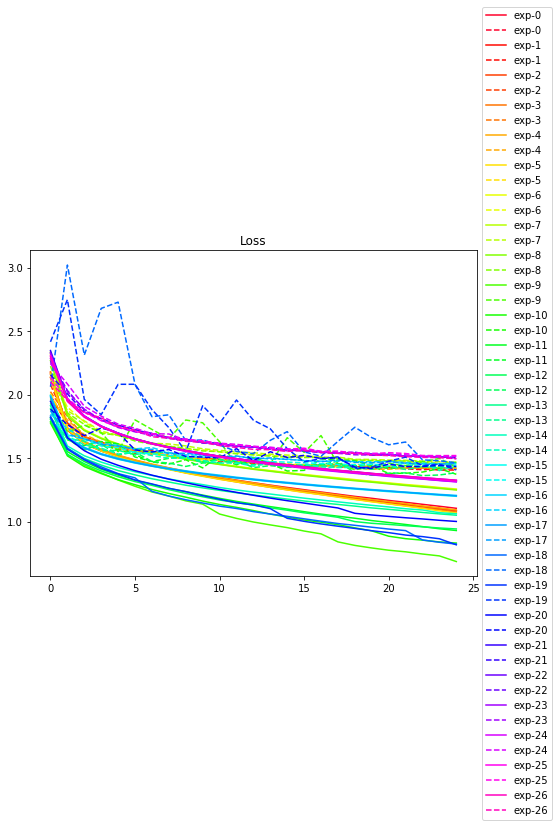

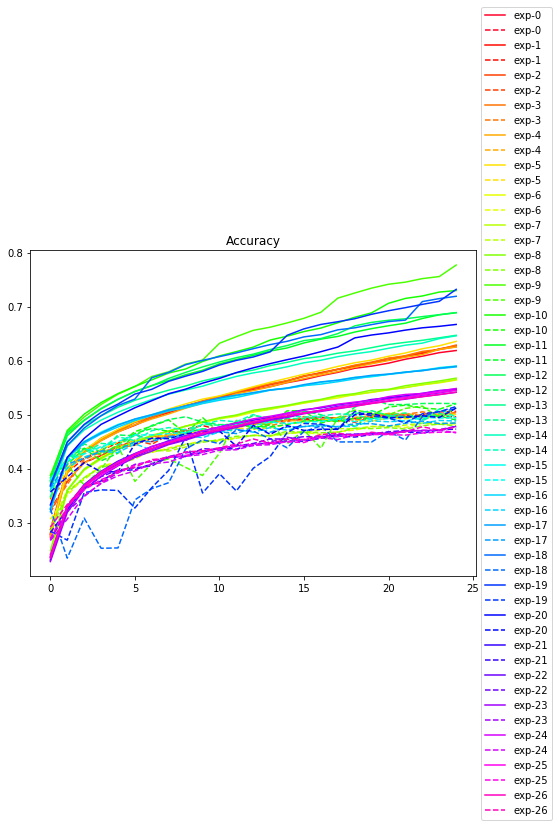

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()